Hypothesis: Stocks follow a random walk. The price movement of a stock today has no statistically significant predicitve power in determing its price tomorrow

In [41]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, linear_model, datasets, feature_selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, mean_squared_error

Tesla Stock Analysis

In [175]:
tesla = pd.read_csv('TSLA.csv')

In [176]:
tesla.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
std,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,213.035003,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07


In [177]:
tesla.head(5) #showing first 5 rows of the original database

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [4]:
tesla.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
tesla['Change in price'] = tesla['Close'] - tesla['Close'].shift(1) #Change in price "today" = price today - price yesterday

In [6]:
tesla.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Change in price
0,2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300,NaN
1,2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100,-0.059999
2,2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800,-1.870001
3,2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800,-2.759998
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900,-3.090000
5,2010-07-07,16.400000,16.629999,14.980000,15.800000,15.800000,6921700,-0.310001
6,2010-07-08,16.139999,17.520000,15.570000,17.459999,17.459999,7711400,1.659999
7,2010-07-09,17.580000,17.900000,16.549999,17.400000,17.400000,4050600,-0.059999
8,2010-07-12,17.950001,18.070000,17.000000,17.049999,17.049999,2202500,-0.350001
9,2010-07-13,17.389999,18.639999,16.900000,18.139999,18.139999,2680100,1.090000


In [7]:
tesla['Change in price'].describe()

count    2415.000000
mean        0.313089
std         7.064706
min       -45.049988
25%        -1.680008
50%         0.069999
75%         2.359999
max       129.429993
Name: Change in price, dtype: float64

In [8]:
tesla_auto_corr = pd.Series(tesla['Change in price'])

In [9]:
print(f'Autocorrelation in price change 1 day lag: {tesla_auto_corr.autocorr(lag=1)}') 
print(f'Autocorrelation in price change 10 day lag: {tesla_auto_corr.autocorr(lag=10)}') 
print(f'Autocorrelation in price change 30 day lag: {tesla_auto_corr.autocorr(lag=30)}') 
print(f'Autocorrelation in price change 90 day lag: {tesla_auto_corr.autocorr(lag=90)}') 

Autocorrelation in price change 1 day lag: 0.03433701804019132
Autocorrelation in price change 10 day lag: 0.012212363115550665
Autocorrelation in price change 30 day lag: 0.039109241000423935
Autocorrelation in price change 90 day lag: -0.0027302116259761773


In [10]:
tesla['tesla_1_day_autocorr'] = tesla_auto_corr.autocorr(lag=1) #autocorrelation todays price change with yesterdays
tesla['tesla_10_day_autocorr'] = tesla_auto_corr.autocorr(lag=10) #autocorrelation todays price change with price 10 days ago
tesla['tesla_30_day_autocorr'] = tesla_auto_corr.autocorr(lag=30) #30 days ago
tesla['Tesla_90_day_autocorr'] = tesla_auto_corr.autocorr(lag=90) #90 days ago

In [11]:
tesla['1_day_close'] = tesla['Close'].shift(-1) #price 1 day in the future from "today"
tesla['10_day_close'] = tesla['Close'].shift(-10)
tesla['30_day_close'] = tesla['Close'].shift(-30)
tesla['90_day_close'] = tesla['Close'].shift(-90)

In [12]:
tesla['Price Up Tomorrow'] = np.where(tesla['Close'].shift(-1)>tesla['Close'], 1, 0) #Price Up Tomorrow Tomorrow is True (1) if tomorrows 
#closing price is higher than todays. This will be our dependent variable we are trying to predict for our classficiation model

In [13]:
tesla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   2416 non-null   object 
 1   Open                   2416 non-null   float64
 2   High                   2416 non-null   float64
 3   Low                    2416 non-null   float64
 4   Close                  2416 non-null   float64
 5   Adj Close              2416 non-null   float64
 6   Volume                 2416 non-null   int64  
 7   Change in price        2415 non-null   float64
 8   tesla_1_day_autocorr   2416 non-null   float64
 9   tesla_10_day_autocorr  2416 non-null   float64
 10  tesla_30_day_autocorr  2416 non-null   float64
 11  Tesla_90_day_autocorr  2416 non-null   float64
 12  1_day_close            2415 non-null   float64
 13  10_day_close           2406 non-null   float64
 14  30_day_close           2386 non-null   float64
 15  90_d

In [14]:
tesla.dropna(axis=0, inplace=True)

In [15]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [16]:
TRAIN_SPLIT = 1743 #represents a 75% training split

In [17]:
tf.random.set_seed(13)

In [18]:
uni_data = tesla[['Change in price']]
uni_data.index = tesla['Date']
uni_data.head(10)

,Change in price
Date,
2010-06-30,-0.059999
2010-07-01,-1.870001
2010-07-02,-2.759998
2010-07-06,-3.090000
2010-07-07,-0.310001
2010-07-08,1.659999
2010-07-09,-0.059999
2010-07-12,-0.350001
2010-07-13,1.090000


Text(0.5, 1.0, 'Tesla 1 Day Price Movement')

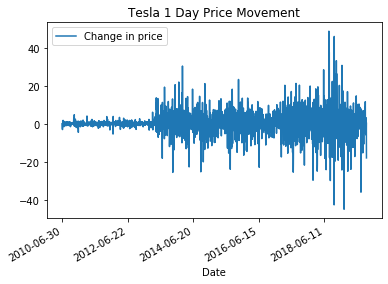

In [19]:
uni_data.plot(subplots=True)
plt.title('Tesla 1 Day Price Movement')

In [20]:
uni_data = uni_data.values

In [21]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [22]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [23]:
univariate_past_history = 30
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [24]:
def create_time_steps(length):
  return list(range(-length, 0))

In [25]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'bo', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [193]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(1743).batch(32).repeat()

tesla_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
tesla_univariate = tesla_univariate.batch(32).repeat()

In [197]:
tesla_lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),tf.keras.layers.Dense(1)])
tesla_lstm_model.add(tf.keras.layers.Dropout(0.2))
tesla_lstm_model.add(tf.keras.layers.Activation('linear'))
tesla_lstm_model.compile(optimizer='adam', loss='mape')

In [198]:
tesla_lstm_model.fit(train_univariate, epochs=10,
                      steps_per_epoch=500,
                      validation_data=tesla_univariate, validation_steps=50)

Epoch 1/10
500/500 [==============================] - 4s 8ms/step - loss: 150.2167 - val_loss: 106.3294
Epoch 2/10
500/500 [==============================] - 4s 8ms/step - loss: 134.3508 - val_loss: 105.6171
Epoch 3/10
500/500 [==============================] - 4s 8ms/step - loss: 134.7365 - val_loss: 104.4136
Epoch 4/10
500/500 [==============================] - 4s 8ms/step - loss: 134.9322 - val_loss: 103.6364
Epoch 5/10
500/500 [==============================] - 4s 8ms/step - loss: 129.1928 - val_loss: 103.9063
Epoch 6/10
500/500 [==============================] - 4s 9ms/step - loss: 130.2753 - val_loss: 103.7960
Epoch 7/10
500/500 [==============================] - 4s 9ms/step - loss: 124.9281 - val_loss: 103.2550
Epoch 8/10
500/500 [==============================] - 4s 9ms/step - loss: 123.0325 - val_loss: 101.2089
Epoch 9/10
500/500 [==============================] - 4s 9ms/step - loss: 127.1801 - val_loss: 102.5756
Epoch 10/10
500/500 [==============================] - 5s 9ms/st

In [199]:
def model_mape(model):
    mape = []
    for i in model.history.history['val_loss']:
        mape.append(i)
    return sum(mape)/(len(model.history.history['val_loss']))

In [200]:
print(f'Tesla dataset MAPE: {model_mape(tesla_lstm_model)}')

Tesla dataset MAPE: 103.68483657836914


In [31]:
def prediction_attempt(model, model_name):
    for x, y in val_univariate.take(3):
      plot = show_plot([x[0].numpy(), y[0].numpy(),
                        model.predict(x)[0]], 0, model_name)
      
      plot.show()

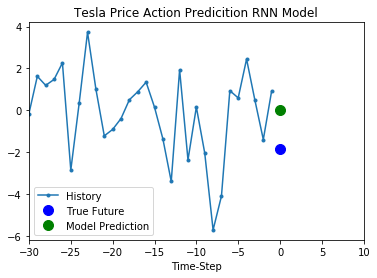

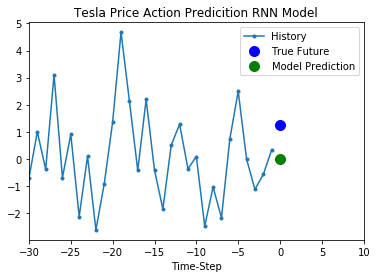

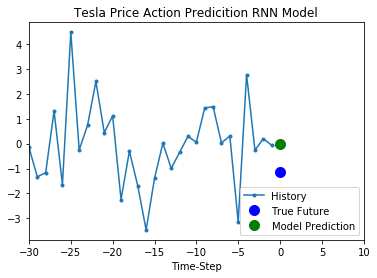

In [32]:
prediction_attempt(tesla_lstm_model, 'Tesla Price Action Predicition RNN Model')

In [33]:
tesla.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Change in price,tesla_1_day_autocorr,tesla_10_day_autocorr,tesla_30_day_autocorr,Tesla_90_day_autocorr,1_day_close,10_day_close,30_day_close,90_day_close,Price Up Tomorrow
1,2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100,-0.059999,0.034337,0.012212,0.039109,-0.00273,21.959999,19.889999,17.600000,24.440001,0
2,2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800,-1.870001,0.034337,0.012212,0.039109,-0.00273,19.200001,20.639999,18.320000,24.980000,0
3,2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800,-2.759998,0.034337,0.012212,0.039109,-0.00273,16.110001,21.910000,18.780001,24.629999,0
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900,-3.090000,0.034337,0.012212,0.039109,-0.00273,15.800000,20.299999,19.150000,29.360001,0
5,2010-07-07,16.400000,16.629999,14.980000,15.800000,15.800000,6921700,-0.310001,0.034337,0.012212,0.039109,-0.00273,17.459999,20.219999,18.770000,28.040001,1
6,2010-07-08,16.139999,17.520000,15.570000,17.459999,17.459999,7711400,1.659999,0.034337,0.012212,0.039109,-0.00273,17.400000,21.000000,18.790001,29.840000,0
7,2010-07-09,17.580000,17.900000,16.549999,17.400000,17.400000,4050600,-0.059999,0.034337,0.012212,0.039109,-0.00273,17.049999,21.290001,19.100000,30.799999,0
8,2010-07-12,17.950001,18.070000,17.000000,17.049999,17.049999,2202500,-0.350001,0.034337,0.012212,0.039109,-0.00273,18.139999,20.950001,20.129999,29.670000,1
9,2010-07-13,17.389999,18.639999,16.900000,18.139999,18.139999,2680100,1.090000,0.034337,0.012212,0.039109,-0.00273,19.840000,20.549999,19.200001,29.490000,1
10,2010-07-14,17.940001,20.150000,17.760000,19.840000,19.840000,4195200,1.700001,0.034337,0.012212,0.039109,-0.00273,19.889999,20.719999,19.900000,29.889999,1


In [87]:
x = tesla[['Open', 'High','Low','Close', 'Volume']]
y = tesla['Price Up Tomorrow']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, shuffle=True)

In [88]:
scaler = StandardScaler()  # standardize our variables
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [89]:
neural_model = MLPClassifier(solver='sgd', alpha=0.0001, hidden_layer_sizes=(5,2)) #set parameters for sgd model

In [90]:
neural_model.fit(x_train, y_train)
print(f'Model accuracy: {neural_model.score(x_train, y_train)}')

Model accuracy: 0.4945496270797476


In [91]:
neural_predict = neural_model.predict(x_test)

In [92]:
print(f'neural network model accuracy is: {neural_model.score(x_train, y_train)}')
print(f'neural network f1 score is: {f1_score(y_test, neural_predict)}')
print(f'neural network precision is: {precision_score(y_test, neural_predict)}')
print(f'neural network recall is: {recall_score(y_test, neural_predict)}')

neural network model accuracy is: 0.4945496270797476
neural network f1 score is: 0.4478632478632479
neural network precision is: 0.46785714285714286
neural network recall is: 0.42950819672131146


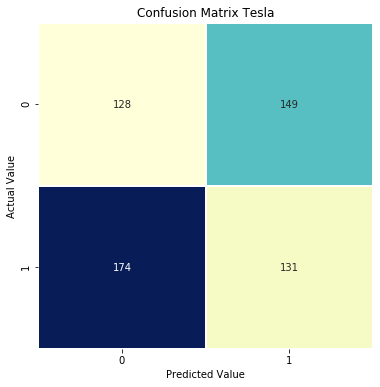

In [93]:
neural_matrix = confusion_matrix(y_test,neural_predict)
plt.subplots(figsize=(6, 6))
sns.heatmap(neural_matrix, annot=True, cbar=False, cmap='YlGnBu',linewidth=1,fmt="d")
plt.ylabel('Actual Value')
plt.xlabel('Predicted Value')
plt.title('Confusion Matrix Tesla');

#1 = Price Up Tomorrow, 0 = Price Down Tomorrow

Tesla analysis does not provide any evidence to reject the null hypothesis


AMD Stock Analysis

In [178]:
amd = pd.read_csv('AMD.csv')

In [179]:
amd.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2.335000e+03
mean,6.434732,6.563961,6.300887,6.433221,6.433221,3.107491e+07
std,3.872391,3.954999,3.792914,3.879124,3.879124,2.791149e+07
min,1.620000,1.690000,1.610000,1.620000,1.620000,0.000000e+00
25%,3.480000,3.550000,3.405000,3.465000,3.465000,1.421670e+07
50%,5.580000,5.720000,5.450000,5.600000,5.600000,2.228020e+07
75%,8.555000,8.710000,8.375000,8.565000,8.565000,3.776905e+07
max,25.510000,27.299999,24.629999,25.260000,25.260000,3.250584e+08


In [180]:
amd.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-05-22,4.43,4.43,4.25,4.26,4.26,8274300
1,2009-05-26,4.26,4.57,4.23,4.53,4.53,16094300
2,2009-05-27,4.57,4.80,4.55,4.71,4.71,21512600
3,2009-05-28,4.75,4.84,4.54,4.70,4.70,18383900
4,2009-05-29,4.71,4.78,4.38,4.54,4.54,24539700


In [45]:
amd.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [46]:
amd.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-05-22,4.43,4.43,4.25,4.26,4.26,8274300
1,2009-05-26,4.26,4.57,4.23,4.53,4.53,16094300
2,2009-05-27,4.57,4.80,4.55,4.71,4.71,21512600
3,2009-05-28,4.75,4.84,4.54,4.70,4.70,18383900
4,2009-05-29,4.71,4.78,4.38,4.54,4.54,24539700
5,2009-06-01,4.69,4.90,4.64,4.73,4.73,26633200
6,2009-06-02,4.68,4.70,4.55,4.56,4.56,24950700
7,2009-06-03,4.55,4.60,4.34,4.48,4.48,19087100
8,2009-06-04,4.57,4.74,4.54,4.65,4.65,19728300
9,2009-06-05,4.84,4.87,4.61,4.63,4.63,18775200


In [47]:
amd['Change in price'] = amd['Close'] - amd['Close'].shift(1)

In [167]:
amd['Change in price'].describe()

count    2244.000000
mean        0.002576
std         0.235656
min        -3.300000
25%        -0.080000
50%         0.000000
75%         0.080000
max         1.690000
Name: Change in price, dtype: float64

In [48]:
amd_auto_corr = pd.Series(amd['Change in price'])

In [168]:
print(f'Amd autocorrelation for change in price at 1 day lag: {amd_auto_corr.autocorr(lag=1)}')
print(f'Amd autocorrelation for change in price at 10 day lag: {amd_auto_corr.autocorr(lag=10)}')
print(f'Amd autocorrelation for change in price at 30 day lag: {amd_auto_corr.autocorr(lag=30)}')
print(f'Amd autocorrelation for change in price at 90 day lag: {amd_auto_corr.autocorr(lag=90)}')

Amd autocorrelation for change in price at 1 day lag: 0.023777529569659586
Amd autocorrelation for change in price at 10 day lag: 0.05096157924621025
Amd autocorrelation for change in price at 30 day lag: -0.029730562060656947
Amd autocorrelation for change in price at 90 day lag: -0.03312900433290952


In [50]:
amd['amd_1_day_autocorr'] = amd_auto_corr.autocorr(lag=1)
amd['amd_10_day_autocorr'] = amd_auto_corr.autocorr(lag=10)
amd['amd_30_day_autocorr'] = amd_auto_corr.autocorr(lag=30)
amd['amd_90_day_autocorr'] = amd_auto_corr.autocorr(lag=90)

In [51]:
amd['1_day_close'] = amd['Close'].shift(-1)
amd['10_day_close'] = amd['Close'].shift(-10)
amd['30_day_close'] = amd['Close'].shift(-30)
amd['90_day_close'] = amd['Close'].shift(-90)

In [52]:
amd['Price Up Tomorrow'] = np.where(amd['Close'].shift(-1)>amd['Close'], 1, 0) #Price Up Tomorrow tomorrow is True (1) if tomorrows 
#closing price is higher than todays. This will be our dependent variable we are trying to predict for our classficiation model

In [53]:
amd.dropna(axis=0, inplace=True)

In [54]:
amd.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Change in price,amd_1_day_autocorr,amd_10_day_autocorr,amd_30_day_autocorr,amd_90_day_autocorr,1_day_close,10_day_close,30_day_close,90_day_close,Price Up Tomorrow
1,2009-05-26,4.26,4.57,4.23,4.53,4.53,16094300,0.27,0.023778,0.050962,-0.029731,-0.033129,4.71,4.75,3.36,5.39,1
2,2009-05-27,4.57,4.80,4.55,4.71,4.71,21512600,0.18,0.023778,0.050962,-0.029731,-0.033129,4.70,4.82,3.48,5.31,0
3,2009-05-28,4.75,4.84,4.54,4.70,4.70,18383900,-0.01,0.023778,0.050962,-0.029731,-0.033129,4.54,4.70,3.49,5.54,0
4,2009-05-29,4.71,4.78,4.38,4.54,4.54,24539700,-0.16,0.023778,0.050962,-0.029731,-0.033129,4.73,4.47,3.56,5.64,1
5,2009-06-01,4.69,4.90,4.64,4.73,4.73,26633200,0.19,0.023778,0.050962,-0.029731,-0.033129,4.56,4.26,3.55,5.54,0


In [55]:
amd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2244 entries, 1 to 2244
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 2244 non-null   object 
 1   Open                 2244 non-null   float64
 2   High                 2244 non-null   float64
 3   Low                  2244 non-null   float64
 4   Close                2244 non-null   float64
 5   Adj Close            2244 non-null   float64
 6   Volume               2244 non-null   int64  
 7   Change in price      2244 non-null   float64
 8   amd_1_day_autocorr   2244 non-null   float64
 9   amd_10_day_autocorr  2244 non-null   float64
 10  amd_30_day_autocorr  2244 non-null   float64
 11  amd_90_day_autocorr  2244 non-null   float64
 12  1_day_close          2244 non-null   float64
 13  10_day_close         2244 non-null   float64
 14  30_day_close         2244 non-null   float64
 15  90_day_close         2244 non-null   f

In [56]:
TRAIN_SPLIT = 1683

In [57]:
tf.random.set_seed(13)

In [58]:
uni_data = amd['Change in price']
uni_data.index = amd['Date']
uni_data.head()

Date
2009-05-26    0.27
2009-05-27    0.18
2009-05-28   -0.01
2009-05-29   -0.16
2009-06-01    0.19
Name: Change in price, dtype: float64

Text(0.5, 1.0, 'AMD 1 Day Price Movement')

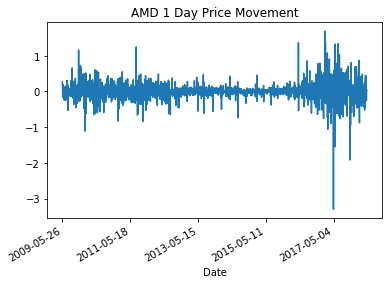

In [59]:
uni_data.plot(subplots=True)
plt.title('AMD 1 Day Price Movement')

In [60]:
uni_data = uni_data.values

In [61]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [62]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [63]:
univariate_past_history = 30
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [64]:
BATCH_SIZE = 32

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(TRAIN_SPLIT).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [65]:
amd_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

amd_lstm_model.compile(optimizer='adam', loss='mape')

In [170]:

amd_lstm_model.fit(train_univariate, epochs=5,
                      steps_per_epoch=500,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/5
500/500 [==============================] - 4s 8ms/step - loss: 158.7749 - val_loss: 100.3754
Epoch 2/5
500/500 [==============================] - 4s 8ms/step - loss: 121.8448 - val_loss: 100.1397
Epoch 3/5
500/500 [==============================] - 4s 8ms/step - loss: 121.0012 - val_loss: 100.6766
Epoch 4/5
500/500 [==============================] - 4s 9ms/step - loss: 117.0507 - val_loss: 100.1816
Epoch 5/5
500/500 [==============================] - 5s 9ms/step - loss: 117.8314 - val_loss: 100.3498


In [171]:
print(f'AMD data set MAPE: {model_mape(amd_lstm_model)}')

AMD data set MAPE: 100.34461669921875


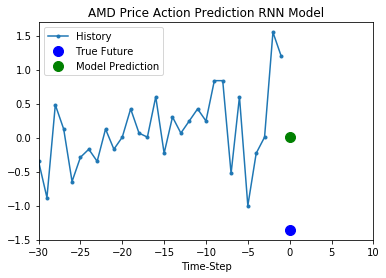

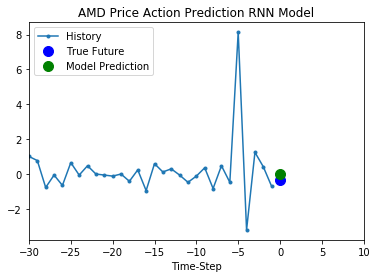

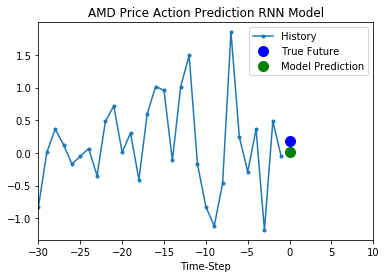

In [69]:
prediction_attempt(amd_lstm_model, 'AMD Price Action Prediction RNN Model')

In [94]:
x = amd[['Open', 'High','Low','Close', 'Volume']]
y = amd['Price Up Tomorrow']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, shuffle=True)

In [95]:
scaler = StandardScaler() 
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [96]:
neural_model = MLPClassifier(solver='sgd', alpha=0.0001, hidden_layer_sizes=(5,2))

In [97]:
neural_model.fit(x_train, y_train)
print(f'Model accuracy: {neural_model.score(x_train, y_train)}')

Model accuracy: 0.5169340463458111


In [98]:
neural_predict = neural_model.predict(x_test)

In [99]:
print(f'neural network model accuracy is: {neural_model.score(x_train, y_train)}')
print(f'neural network f1 score is: {f1_score(y_test, neural_predict)}')
print(f'neural network precision is: {precision_score(y_test, neural_predict)}')
print(f'neural network recall is: {recall_score(y_test, neural_predict)}')

neural network model accuracy is: 0.5169340463458111
neural network f1 score is: 0.23157894736842102
neural network precision is: 0.4230769230769231
neural network recall is: 0.15942028985507245


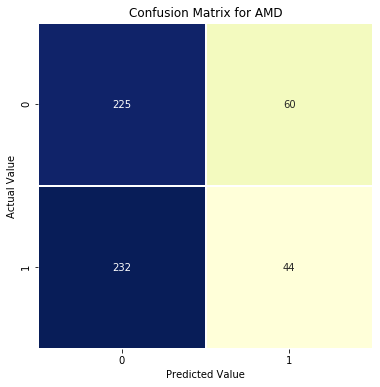

In [102]:
neural_matrix = confusion_matrix(y_test,neural_predict)

plt.subplots(figsize=(6, 6))
sns.heatmap(neural_matrix, annot=True, cbar=False, cmap='YlGnBu',linewidth=1,fmt="d")
plt.ylabel('Actual Value')
plt.xlabel('Predicted Value')
plt.title('Confusion Matrix for AMD');

Google Stock analysis

In [181]:
google = pd.read_csv('GOOGL.csv')

In [182]:
google.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2.335000e+03
mean,550.725409,555.136744,545.908515,550.662757,550.662757,3.764886e+06
std,278.136894,280.349025,275.855161,278.228484,278.228484,2.764696e+06
min,196.171173,199.524521,195.195190,196.946945,196.946945,5.206000e+05
25%,299.286773,301.759247,297.197204,299.144135,299.144135,1.734650e+06
50%,526.211182,532.780029,521.909973,527.767761,527.767761,3.250200e+06
75%,757.760010,763.745025,752.024994,758.524993,758.524993,4.891800e+06
max,1289.119995,1291.439941,1263.000000,1285.500000,1285.500000,2.961990e+07


In [183]:
google.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [185]:
google.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700
1,2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700
2,2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500
3,2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200
4,2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100


In [107]:
google['Change in price'] = google['Close'] - google['Close'].shift(1)

In [172]:
google['Change in price'].describe()

count    2244.000000
mean        0.390759
std         8.188028
min       -62.390015
25%        -2.796562
50%         0.260254
75%         3.810059
max        97.839966
Name: Change in price, dtype: float64

In [108]:
google_auto_corr = pd.Series(google['Change in price'])

In [109]:
google.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Change in price
0,2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700,NaN
1,2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700,5.435440
2,2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500,0.600601
3,2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200,2.422425
4,2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100,3.418411
5,2009-06-01,209.574570,215.015015,209.474472,213.493500,213.493500,6638100,4.669678
6,2009-06-02,213.338333,215.195190,211.911911,214.414413,214.414413,5241900,0.920913
7,2009-06-03,213.213211,216.446442,212.212219,216.041046,216.041046,7058500,1.626633
8,2009-06-04,217.867874,220.840836,217.467468,220.360367,220.360367,7268900,4.319321
9,2009-06-05,222.757751,223.893890,219.949951,222.382385,222.382385,7354200,2.022018


In [173]:
print(f'Google autocorrelation for change in price at 1 day lag: {google_auto_corr.autocorr(lag=1)}')
print(f'Google autocorrelation for change in price at 10 day lag: {google_auto_corr.autocorr(lag=10)}')
print(f'Google autocorrelation for change in price at 30 day lag: {google_auto_corr.autocorr(lag=30)}')
print(f'Google autocorrelation for change in price at 90 day lag: {google_auto_corr.autocorr(lag=90)}')

Google autocorrelation for change in price at 1 day lag: 0.054036428294845625
Google autocorrelation for change in price at 10 day lag: -0.0022905181848053065
Google autocorrelation for change in price at 30 day lag: 0.0036033938477389965
Google autocorrelation for change in price at 90 day lag: 0.009940762169914592


In [111]:
google.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             2335 non-null   object 
 1   Open             2335 non-null   float64
 2   High             2335 non-null   float64
 3   Low              2335 non-null   float64
 4   Close            2335 non-null   float64
 5   Adj Close        2335 non-null   float64
 6   Volume           2335 non-null   int64  
 7   Change in price  2334 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 146.1+ KB


In [112]:
google['1_day_close'] = google['Close'].shift(-1)
google['10_day_close'] = google['Close'].shift(-10)
google['30_day_close'] = google['Close'].shift(-30)
google['90_day_close'] = google['Close'].shift(-90)

In [113]:
google['google_1_day_autocorr'] = google_auto_corr.autocorr(lag=1)
google['google_10_day_autocorr'] = google_auto_corr.autocorr(lag=10)
google['google_30_day_autocorr'] = google_auto_corr.autocorr(lag=30)
google['google_90_day_autocorr'] = google_auto_corr.autocorr(lag=90)

In [114]:
google['Price Up Tomorrow Tomorrow'] = np.where(google['Close'].shift(-1)>google['Close'], 1, 0) #Price up Tomorrow is True (1) if tomorrows 
#closing price is higher than todays. 

In [115]:
google.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Change in price,1_day_close,10_day_close,30_day_close,90_day_close,google_1_day_autocorr,google_10_day_autocorr,google_30_day_autocorr,google_90_day_autocorr,Price Up Tomorrow Tomorrow
0,2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700,NaN,202.382385,219.604599,198.513519,248.173172,0.054036,-0.002291,0.003603,0.009941,1
1,2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700,5.435440,202.982986,218.028030,201.446442,243.843842,0.054036,-0.002291,0.003603,0.009941,1
2,2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500,0.600601,205.405411,216.516510,205.400406,242.532532,0.054036,-0.002291,0.003603,0.009941,1
3,2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200,2.422425,208.823822,214.714722,207.407410,244.504501,0.054036,-0.002291,0.003603,0.009941,1
4,2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100,3.418411,213.493500,212.632629,212.362366,249.619614,0.054036,-0.002291,0.003603,0.009941,1
5,2009-06-01,209.574570,215.015015,209.474472,213.493500,213.493500,6638100,4.669678,214.414413,208.593597,212.557556,259.029022,0.054036,-0.002291,0.003603,0.009941,1
6,2009-06-02,213.338333,215.195190,211.911911,214.414413,214.414413,5241900,0.920913,216.041046,208.208206,219.304306,257.347351,0.054036,-0.002291,0.003603,0.009941,1
7,2009-06-03,213.213211,216.446442,212.212219,216.041046,216.041046,7058500,1.626633,220.360367,207.787781,221.521515,258.383392,0.054036,-0.002291,0.003603,0.009941,1
8,2009-06-04,217.867874,220.840836,217.467468,220.360367,220.360367,7268900,4.319321,222.382385,207.237244,215.340347,262.282288,0.054036,-0.002291,0.003603,0.009941,1
9,2009-06-05,222.757751,223.893890,219.949951,222.382385,222.382385,7354200,2.022018,219.604599,210.255249,215.300293,263.318329,0.054036,-0.002291,0.003603,0.009941,0


In [116]:
google.dropna(axis=0, inplace=True) #remove rows with null values from data set

In [117]:
google.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2244 entries, 1 to 2244
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        2244 non-null   object 
 1   Open                        2244 non-null   float64
 2   High                        2244 non-null   float64
 3   Low                         2244 non-null   float64
 4   Close                       2244 non-null   float64
 5   Adj Close                   2244 non-null   float64
 6   Volume                      2244 non-null   int64  
 7   Change in price             2244 non-null   float64
 8   1_day_close                 2244 non-null   float64
 9   10_day_close                2244 non-null   float64
 10  30_day_close                2244 non-null   float64
 11  90_day_close                2244 non-null   float64
 12  google_1_day_autocorr       2244 non-null   float64
 13  google_10_day_autocorr      2244 

In [118]:
google.head(10) #verification tags have been computed correctly

,Date,Open,High,Low,Close,Adj Close,Volume,Change in price,1_day_close,10_day_close,30_day_close,90_day_close,google_1_day_autocorr,google_10_day_autocorr,google_30_day_autocorr,google_90_day_autocorr,Price Up Tomorrow Tomorrow
1,2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700,5.435440,202.982986,218.028030,201.446442,243.843842,0.054036,-0.002291,0.003603,0.009941,1
2,2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500,0.600601,205.405411,216.516510,205.400406,242.532532,0.054036,-0.002291,0.003603,0.009941,1
3,2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200,2.422425,208.823822,214.714722,207.407410,244.504501,0.054036,-0.002291,0.003603,0.009941,1
4,2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100,3.418411,213.493500,212.632629,212.362366,249.619614,0.054036,-0.002291,0.003603,0.009941,1
5,2009-06-01,209.574570,215.015015,209.474472,213.493500,213.493500,6638100,4.669678,214.414413,208.593597,212.557556,259.029022,0.054036,-0.002291,0.003603,0.009941,1
6,2009-06-02,213.338333,215.195190,211.911911,214.414413,214.414413,5241900,0.920913,216.041046,208.208206,219.304306,257.347351,0.054036,-0.002291,0.003603,0.009941,1
7,2009-06-03,213.213211,216.446442,212.212219,216.041046,216.041046,7058500,1.626633,220.360367,207.787781,221.521515,258.383392,0.054036,-0.002291,0.003603,0.009941,1
8,2009-06-04,217.867874,220.840836,217.467468,220.360367,220.360367,7268900,4.319321,222.382385,207.237244,215.340347,262.282288,0.054036,-0.002291,0.003603,0.009941,1
9,2009-06-05,222.757751,223.893890,219.949951,222.382385,222.382385,7354200,2.022018,219.604599,210.255249,215.300293,263.318329,0.054036,-0.002291,0.003603,0.009941,0
10,2009-06-08,219.969971,220.680679,217.277283,219.604599,219.604599,6191200,-2.777786,218.028030,203.878876,214.164169,267.927917,0.054036,-0.002291,0.003603,0.009941,0


In [140]:
TRAIN_SPLIT = 1684

In [141]:
tf.random.set_seed(13)

In [142]:
uni_data = google['Change in price']
uni_data.index = google['Date']
uni_data.head()

Date
2009-05-26    5.435440
2009-05-27    0.600601
2009-05-28    2.422425
2009-05-29    3.418411
2009-06-01    4.669678
Name: Change in price, dtype: float64

Text(0.5, 1.0, 'Google 1 Day Price Movement')

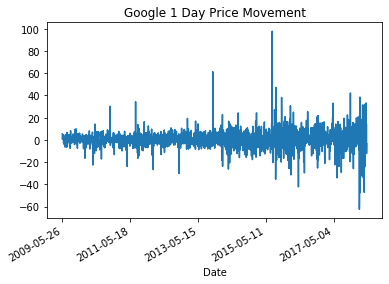

In [143]:
uni_data.plot(subplots=True)
plt.title('Google 1 Day Price Movement')

In [144]:
uni_data = uni_data.values

In [145]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [146]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [147]:
univariate_past_history = 30
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [150]:
BATCH_SIZE = 32


train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(TRAIN_SPLIT).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [151]:
google_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

google_lstm_model.compile(optimizer='adam', loss='mape')

In [152]:
EVALUATION_INTERVAL = 500
EPOCHS = 5

google_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/5
500/500 [==============================] - 4s 8ms/step - loss: 176.6157 - val_loss: 104.5491
Epoch 2/5
500/500 [==============================] - 4s 8ms/step - loss: 123.8248 - val_loss: 105.3957
Epoch 3/5
500/500 [==============================] - 4s 8ms/step - loss: 119.0937 - val_loss: 104.7126
Epoch 4/5
500/500 [==============================] - 5s 10ms/step - loss: 119.4422 - val_loss: 103.1741
Epoch 5/5
500/500 [==============================] - 5s 10ms/step - loss: 119.1553 - val_loss: 102.4444


In [153]:
print(f'Google data MAPE: {model_mape(google_lstm_model)}')

Google data MAPE: 104.05519104003906


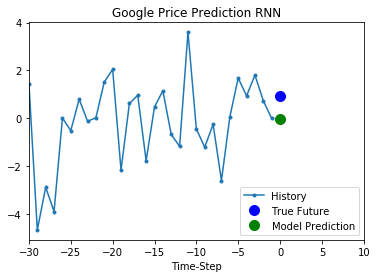

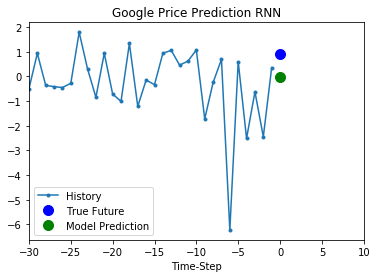

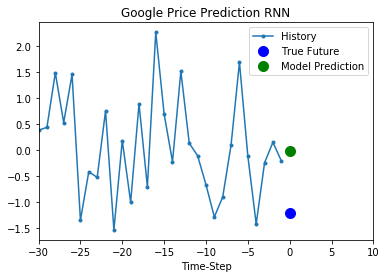

In [155]:
prediction_attempt(google_lstm_model, 'Google Price Prediction RNN')

In [157]:
x = amd[['Open', 'High','Low','Close', 'Volume']]
y = amd['Price Up Tomorrow']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, shuffle=True)

In [158]:
scaler = StandardScaler() 
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [159]:
neural_model = MLPClassifier(solver='sgd', alpha=0.0001, hidden_layer_sizes=(5,2))

In [160]:
neural_model.fit(x_train, y_train)
print(f'Model accuracy: {neural_model.score(x_train, y_train)}')

Model accuracy: 0.48960190136660725


In [161]:
neural_predict = neural_model.predict(x_test)

In [186]:
print(f'Google classification model accuracy is: {neural_model.score(x_train, y_train)}')
print(f'Google classification f1 score is: {f1_score(y_test, neural_predict)}')
print(f'Google classification precision is: {precision_score(y_test, neural_predict)}')
print(f'Google classification recall is: {recall_score(y_test, neural_predict)}')

Google classification model accuracy is: 0.48960190136660725
Google classification f1 score is: 0.5855161787365177
Google classification precision is: 0.5121293800539084
Google classification recall is: 0.6834532374100719


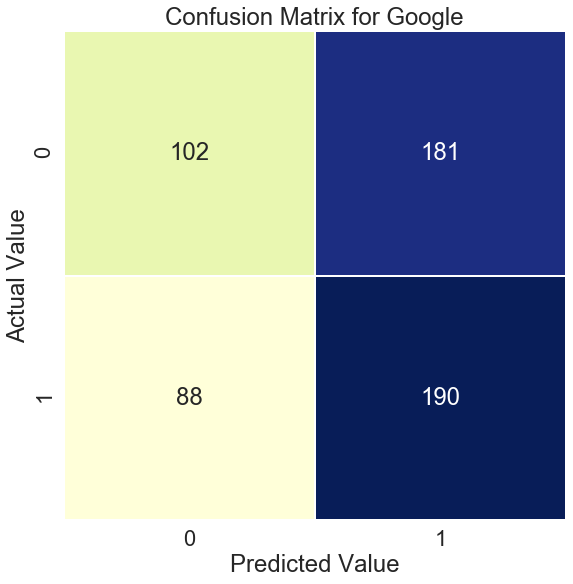

In [166]:
neural_matrix = confusion_matrix(y_test,neural_predict)

plt.subplots(figsize=(9, 9))
sns.heatmap(neural_matrix, annot=True, cbar=False, cmap='YlGnBu',linewidth=1,fmt="d")
plt.ylabel('Actual Value')
plt.xlabel('Predicted Value')
plt.title('Confusion Matrix for Google');